<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import torch
import torch
import torch.nn as nn

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Dowmnload the dataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_data = MNIST(root = 'drive/MyDrive/PyTorch_projects/03_pytorch_computer_vision_datasets',
                   train = True,
                   download = True,
                   transform = ToTensor())

test_data = MNIST(root = 'drive/MyDrive/PyTorch_projects/03_pytorch_computer_vision_datasets',
                  train = False,
                  download = True,
                  transform = ToTensor())

print(len(train_data), len(test_data))

60000 10000


In [ ]:
# First image shape and label
first_image, first_label = train_data[0]

print(first_image.shape)
print(first_label)

torch.Size([1, 28, 28])
5


In [ ]:
print(dir(train_data))

In [ ]:
# Check available classes
classes = train_data.classes
print(classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## 2. Visualize different samples of the MNIST training dataset.

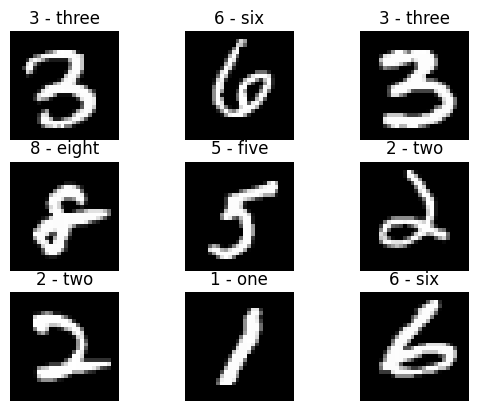

In [ ]:
import random
import matplotlib.pyplot as plt

nrows = 3
ncols = 3

for i in range(9):
  random_index = random.randint(0, len(train_data.data))
  image, label = train_data[random_index]
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(image.squeeze(), cmap = 'gray')
  plt.title(classes[label])
  plt.axis(False)

plt.show()

## 3. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset = train_data, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = 32, shuffle = False)

## 4. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [ ]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.output_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_layer_1(x)
    x = self.conv_layer_2(x)
    return self.output_layer(x)

model = TinyVGG(input_shape=1,
                    hidden_units=10,
                    output_shape=10).to(device)

## 5. Train the model

In [ ]:
import sklearn.metrics as metrics
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.1)

In [ ]:
# Training phase
%%time

epochs = 5

for epoch in range(epochs):
  model.train()
  accuracy = 0
  train_loss = 0
  for X, y in train_dataloader:
    X = X.to(device)
    y = y.to(device)

    y_logits = model(X)
    y_pred = y_logits.argmax(dim = 1)

    loss = loss_fn(y_logits, y)

    accuracy += metrics.accuracy_score(y.cpu(), y_pred.cpu())
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  print(f"Epoch {epoch}, train accuracy: {accuracy/len(train_dataloader)}")


Epoch 0, train accuracy: 0.8346833333333333
Epoch 1, train accuracy: 0.9755666666666667
Epoch 2, train accuracy: 0.98095
Epoch 3, train accuracy: 0.9831666666666666
Epoch 4, train accuracy: 0.9855333333333334
CPU times: user 1min 6s, sys: 541 ms, total: 1min 6s
Wall time: 1min 7s


In [ ]:
# Testing phase
model.eval()
y_preds = []
with torch.inference_mode():
  test_accuracy = 0
  for X, y in test_dataloader:
    X = X.to(device)
    y = y.to(device)
    y_logits = model(X)
    y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
    y_preds.append(y_pred.cpu())
    loss = loss_fn(y_logits, y)
    test_accuracy += metrics.accuracy_score(y.cpu(), y_pred.cpu())

  test_accuracy /= len(test_dataloader)

In [ ]:
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.9877196485623003


## 6. Make predictions

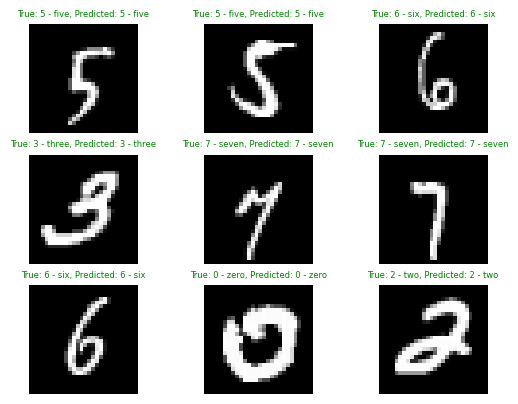

In [ ]:
nrows = 3
ncols = 3

for i in range(9):
  random_index = random.randint(0, len(test_data.data))
  image, label = train_data[random_index]
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(image.squeeze(), cmap = 'gray')

  # make predictions
  y_logits = model(image.unsqueeze(dim=0).to(device))
  pred_label = torch.softmax(y_logits.cpu(), dim = 1).argmax(dim = 1)
  if pred_label == label:
    plt.title(f"True: {classes[label]}, Predicted: {classes[pred_label]}", color = 'green', fontsize = 6)
  else:
    plt.title(f"True: {classes[label]}, Predicted: {classes[pred_label]}", color = 'red', fontsize = 6)
  plt.axis(False)

plt.show()

## 7. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [ ]:
y_preds[:2]

[tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 8, 4, 9, 6, 6, 5,
         4, 0, 7, 4, 0, 1, 3, 1]),
 tensor([3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0,
         4, 1, 9, 5, 7, 8, 9, 3])]

In [ ]:
y_preds = torch.cat(y_preds)
y_preds[0:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [ ]:
test_data.targets[:5]

tensor([7, 2, 1, 0, 4])

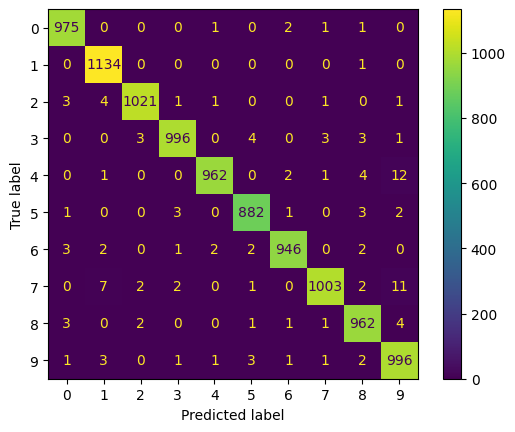

In [ ]:
cm = metrics.confusion_matrix(y_true = test_data.targets, y_pred = y_preds, labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

disp.plot()
plt.show()